## Extracting LSTM features and Feature Maps from the main data
To better understand the code, check out `./prep_files/preprocessing_synced_for_MTL.ipynb`. That notebook explains the thought process behind this code on a sample dataset whilst this goes straight to the point.

In [1]:
import pandas as pd
import numpy as np
import src.preprocess
from src.preprocess import LSTM_featureExtractor, Prep_data_for_CNN

In [ ]:
data = pd.read_csv('./data/concat_users.csv')

In [3]:
data.groupby(['User', 'Position'])['Segment'].count()

User   Position
User1  Bag         304434
       Hand        304438
       Hips        304434
       Torso       304430
User2  Bag         372171
       Hand        372170
       Hips        372172
       Torso       372177
User3  Bag         347627
       Hand        347627
       Hips        347627
       Torso       347626
Name: Segment, dtype: int64

In [7]:
sub_segmented_data = src.preprocess.create_sub_segments(data, window_size=112, overlap=0.5)
sub_segmented_data.to_csv('./data/sub_segmented_data.csv', index=False, header=True)

In [10]:
del data, sub_segmented_data

-----

In [12]:
subbed_data = pd.read_csv('./data/sub_segmented_data.csv')

In [13]:
subbed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8092672 entries, 0 to 8092671
Data columns (total 18 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time_ms         float64
 1   acceleration_x  float64
 2   acceleration_y  float64
 3   acceleration_z  float64
 4   gyroscope_x     float64
 5   gyroscope_y     float64
 6   gyroscope_z     float64
 7   orientation_w   float64
 8   orientation_x   float64
 9   orientation_y   float64
 10  orientation_z   float64
 11  Date            int64  
 12  Position        object 
 13  Coarse_label    float64
 14  Fine_label      float64
 15  Segment         int64  
 16  User            object 
 17  Sub_Segment     int64  
dtypes: float64(13), int64(3), object(2)
memory usage: 1.1+ GB


### Feature Extraction for LSTM

In [14]:
lstm_featExtract = LSTM_featureExtractor(subbed_data, num_features=6, window=112)

In [15]:
lstm_features, lstm_labels = lstm_featExtract.feature_extractor(start=0)

In [18]:
np.save('./data/lstm_features_labels/full_lstm_features.npy', lstm_features)
np.save('./data/lstm_features_labels/full_lstm_labels.npy', lstm_labels)

In [19]:
print(lstm_features.shape)  # Should be (num_samples, window, num_features)
print(lstm_labels.shape)    # Should be (num_samples,)

(72256, 112, 6)
(72256,)


In [20]:
del lstm_features, lstm_labels

### Feature Extraction for CNN-RNN

In [21]:
subbed_data.query("Coarse_label == 5.0 & Position=='Hand'").groupby(['User','Segment'])[['Sub_Segment']].count()

Sub_Segment
User  Segment             
User1 5              35728
      7              33040
      9              18928
      12             11088
User2 64             67088
      66             14672
      70             26880
      73             27440
      75             17584
User3 22             50288

This data has 3 drivers whilst my sample had 2.

In [22]:
subbed_data.query("Coarse_label == 5.0").groupby('User')[['Segment','Sub_Segment']].nunique()

,Segment,Sub_Segment
User,,
User1,4,882
User2,5,1372
User3,1,449


In [29]:
windowed_df = Prep_data_for_CNN().get_window_df_from_dir('./data/sub_segmented_data.csv',
                                                         prep_for_FMAPextract=False)

time it took: `304m 0.5s`

In [30]:
windowed_df.to_csv('./data/windowed_df.csv', index=False, header=True)

I should have set `prep_for_FMAPextract=True` because I need the full windowed_df to be able to split it into train and test without leaking data into the SimpleCNN. I'll do it manually.

In [31]:
len(windowed_df)

36304

In [33]:
windowed_df['user'] = windowed_df['user_act'].values
del windowed_df['user_act']

In [36]:
windowed_df = Prep_data_for_CNN().prep_for_FMAPextract(subbed_data, windowed_df)

# change other labels to `Not_driving`  (a dummy label)
windowed_df['user_act'] = windowed_df['user'].values
idx_users = windowed_df.query('coarse_label == 5.0').index
df_with_drivers = windowed_df.index.isin(idx_users)
windowed_df.loc[~df_with_drivers, 'user'] = 'Not_driving'

In [37]:
windowed_df.to_csv('./data/full_windowed_df.csv', index=False, header=True)

In [38]:
len(windowed_df)

72256

----

This `full_windowed_df` is made up of duplicates and interpolated data. As a result, I'll need to take 80:20 of the duplicates (original and corr dupe) as well as 80:20 of interpolated data.

In [2]:
def converter(instr):
    return np.fromstring(instr[1:-1],sep=' ')

windowed_df = pd.read_csv(
    './data/full_windowed_df.csv',
    converters={
        'long_acc_window': converter,
        'tranv_acc_window': converter,
        'ang_vel_window': converter
    }
)

In [3]:
windowed_df.columns

Index(['user', 'coarse_label', 'segment', 'position', 'window_index',
       'long_acc_window', 'tranv_acc_window', 'ang_vel_window', 'Interp_Flag',
       'Dupl_Flag', 'Train_Flag', 'user_act'],
      dtype='object')

In [4]:
idx_non_dupe = windowed_df.query("Dupl_Flag==0 & Interp_Flag==0").index
idx_interp = windowed_df.query("Dupl_Flag==0 & Interp_Flag==1").index

For each non_dupe, it's corresponding duplicate is the next idx

Get training and test index

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
tr_idx_nondupe, test_idx_nondupe = train_test_split(idx_non_dupe,
                                                    test_size=0.2,
                                                    stratify=windowed_df.loc[idx_non_dupe, 'user_act'].values,
                                                    random_state=42)

tr_idx_interp, test_idx_interp = train_test_split(idx_interp,
                                                  test_size=0.2,
                                                  stratify=windowed_df.loc[idx_interp, 'user_act'].values,
                                                  random_state=42)

In [7]:
# get the idx for the duplicates
tr_idx_dupe = tr_idx_nondupe+1
test_idx_dupe = test_idx_nondupe+1

In [8]:
train_idx = np.concatenate([tr_idx_nondupe, tr_idx_dupe, tr_idx_interp], axis=None)
test_idx = np.concatenate([test_idx_nondupe, test_idx_dupe, test_idx_interp], axis=None)

In [9]:
TR_tr_idx_nondupe, VAL_tr_idx_nondupe = train_test_split(tr_idx_nondupe,
                                                    test_size=0.2,
                                                    stratify=windowed_df.loc[tr_idx_nondupe, 'user_act'].values,
                                                    random_state=42)

TR_tr_idx_interp, VAL_tr_idx_interp = train_test_split(tr_idx_interp,
                                                  test_size=0.2,
                                                  stratify=windowed_df.loc[tr_idx_interp, 'user_act'].values,
                                                  random_state=42)

# get the idx for the duplicates
TR_tr_idx_dupe = TR_tr_idx_nondupe+1
VAL_tr_idx_dupe = VAL_tr_idx_nondupe+1

# get new training and validation set
TR_train_idx = np.concatenate([TR_tr_idx_nondupe, TR_tr_idx_dupe, TR_tr_idx_interp], axis=None)
VAL_train_idx = np.concatenate([VAL_tr_idx_nondupe, VAL_tr_idx_dupe, VAL_tr_idx_interp], axis=None)

In [10]:
# ## subsetting only the training data
# windowed_df = windowed_df.loc[train_idx, :]

Begin hyperparam tuning for SimpleCNN

In [11]:
X_tr, y_tr, uniq = Prep_data_for_CNN().prep_input_for_CNN(windowed_df.loc[TR_train_idx, :])#.sample(1000))
X_val, y_val, _ = Prep_data_for_CNN().prep_input_for_CNN(windowed_df.loc[VAL_train_idx, :])#.sample(500))
X_test, y_test, _ = Prep_data_for_CNN().prep_input_for_CNN(windowed_df.loc[test_idx, :])#.sample(500))

# normalizing X
mean = X_tr.mean(axis=(0, 2), keepdims=True)
std = X_tr.std(axis=(0, 2), keepdims=True)

X_tr = (X_tr - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

In [12]:
uniq, np.unique(y_tr)

(array(['Not_driving', 'User1', 'User2', 'User3'], dtype='<U11'),
 array([0, 1, 2, 3], dtype=int64))

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [14]:
X_tr.shape

(46240, 3, 224)

In [15]:
class_weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr), dtype=torch.float32)
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [16]:
class_weights

tensor([ 0.2936,  5.0925,  3.3057, 10.5571], device='cuda:0')

In [17]:
from src.dataset import SignalsDataset

In [18]:
# Create datasets for each feature
feature_indices = {'long_acc': 0, 'tranv_acc': 1, 'ang_vel': 2}

## dataset for extracting feature maps from data
train_datasets = {feature: SignalsDataset(X_tr, y_tr, idx) for feature, idx in feature_indices.items()}
valid_datasets = {feature: SignalsDataset(X_val, y_val, idx) for feature, idx in feature_indices.items()}
test_datasets = {feature: SignalsDataset(X_test, y_test, idx) for feature, idx in feature_indices.items()}

In [19]:
from src.engine import simpleCNN_engine
from src.model_simpleCNN import SimpleCNN
from src.dataset import SignalsDataset
from src.preprocess import Prep_data_for_CNN
from src.hyperparam import RayTuning
from ray import tune, train

from IPython.display import display, HTML

# Load custom CSS file
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">')  # Ensure the path is correct
display(css)

In [20]:
SimpleCNN()

SimpleCNN(
  (conv1): Conv1d(1, 224, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm1): BatchNorm1d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=25088, out_features=4, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)

#### Hyperparam Tuning

Hyperparam Tuning - Long Model

In [20]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10, 15]),  # for ReduceLROnPlateau
    "epochs": tune.choice([30]),
    "batch_size": tune.choice([32, 64])
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'SimpleCNN_long'
model = SimpleCNN
modelType = 'SimpleCNN'
engine = simpleCNN_engine

In [21]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [22]:
mytuner.main(train_datasets['long_acc'], valid_datasets['long_acc'], 
             test_datasets['long_acc'], num_samples=25)

(train_model pid=13880) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_long/trial_a8304_00000/checkpoint_000000)
(train_model pid=13880) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_long/trial_a8304_00000/checkpoint_000001)
(train_model pid=13880) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_long/trial_a8304_00000/checkpoint_000002)
(train_model pid=13880) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Re

Best trial config: {'optimizer': 'adam', 'lr': 0.006482722864364993, 'scheduler': 'ReduceLROnPlateau', 'gamma': 0.8185367503936773, 'patience': 15, 'epochs': 30, 'batch_size': 32}
Best trial final validation loss: 1.3836872604011832
Best trial final validation accuracy: 84.1823%
Test Accuracy: 0.8532484605272261
Best trial test set accuracy: 0.8532%


Hyperparam Tuning - Tranv Model

In [23]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10, 15]),  # for ReduceLROnPlateau
    "epochs": tune.choice([30]),
    "batch_size": tune.choice([32, 64])
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'SimpleCNN_tranv'
model = SimpleCNN
modelType = 'SimpleCNN'
engine = simpleCNN_engine

In [24]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [25]:
mytuner.main(train_datasets['tranv_acc'], valid_datasets['tranv_acc'], 
             test_datasets['tranv_acc'], num_samples=25)

(train_model pid=21988) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_tranv/trial_27755_00000/checkpoint_000000)
(train_model pid=21988) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_tranv/trial_27755_00000/checkpoint_000001)
(train_model pid=21988) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_tranv/trial_27755_00000/checkpoint_000002)
(train_model pid=21988) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science

2024-07-26 08:08:26,464	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_tranv' in 0.0289s.
2024-07-26 08:08:26,495	INFO tune.py:1041 -- Total run time: 14473.90 seconds (14473.83 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.0015831811326078972, 'scheduler': 'exp', 'gamma': 0.5287373400905854, 'patience': 5, 'epochs': 30, 'batch_size': 32}
Best trial final validation loss: 1.3844412874780307
Best trial final validation accuracy: 84.1823%
Test Accuracy: 0.8532484605272261
Best trial test set accuracy: 0.8532%


Hyperparam Tuning - Ang. Vel Model

In [26]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10, 15]),  # for ReduceLROnPlateau
    "epochs": tune.choice([30]),
    "batch_size": tune.choice([32, 64])
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'SimpleCNN_ang_vel'
model = SimpleCNN
modelType = 'SimpleCNN'
engine = simpleCNN_engine

In [27]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [28]:
mytuner.main(train_datasets['ang_vel'], valid_datasets['ang_vel'], 
             test_datasets['ang_vel'], num_samples=25)

2024-07-26 11:22:28,268	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_ang_vel' in 0.0357s.
2024-07-26 11:22:28,293	INFO tune.py:1041 -- Total run time: 11621.73 seconds (11621.64 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.0029451848340113214, 'scheduler': 'ReduceLROnPlateau', 'gamma': 0.12270840309802439, 'patience': 5, 'epochs': 30, 'batch_size': 32}
Best trial final validation loss: 1.386783880752753
Best trial final validation accuracy: 84.1823%
Test Accuracy: 0.8532484605272261
Best trial test set accuracy: 0.8532%


To view tensorboard, run below in terminal;

`tensorboard --logdir="c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/SimpleCNN_long"`

-----

#### Model Training
Time to train the model with the given optimal hyperparameters

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.model_simpleCNN import SimpleCNN
from src.engine import simpleCNN_engine

In [22]:
np.random.seed(42)

batch_size = 32
train_dl_long = DataLoader(train_datasets['long_acc'], batch_size, shuffle=True, num_workers=4)
train_dl_tranv = DataLoader(train_datasets['tranv_acc'], batch_size, shuffle=True, num_workers=4)
train_dl_angvel = DataLoader(train_datasets['ang_vel'], batch_size, shuffle=True, num_workers=4)

valid_dl_long = DataLoader(valid_datasets['long_acc'], batch_size, shuffle=True, num_workers=4)
valid_dl_tranv = DataLoader(valid_datasets['tranv_acc'], batch_size, shuffle=True, num_workers=4)
valid_dl_angvel = DataLoader(valid_datasets['ang_vel'], batch_size, shuffle=True, num_workers=4)

test_dl_long = DataLoader(test_datasets['long_acc'], batch_size, shuffle=False, num_workers=2)
test_dl_tranv = DataLoader(test_datasets['tranv_acc'], batch_size, shuffle=False, num_workers=2)
test_dl_angvel = DataLoader(test_datasets['ang_vel'], batch_size, shuffle=False, num_workers=2)

Longitudinal acceleration

In [23]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_long = SimpleCNN()
optimizer_long = optim.Adam(model_long.parameters(), lr=0.00011113828101205411, weight_decay=1e-4)
scheduler_long = optim.lr_scheduler.ExponentialLR(optimizer_long, gamma=0.8492356384312725)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_long = model_long.to(device)

In [24]:
engine_long = simpleCNN_engine(model_long, optimizer_long, scheduler_long, criterion, device)

In [25]:
long_hist = engine_long.train_validation(train_dl_long, valid_dl_long, epochs=20, save_path='./model_checkpoint/run2_simpleCNN_long_chkpt.pth')

np.save('./model_checkpoint/run2_long_history.npy', np.array(long_hist))

   Epoch [1/20], Train Loss: 1.7608, Train Accuracy: 31.34%, Val Loss: 1.4588, Val Accuracy: 24.67%
   Epoch [2/20], Train Loss: 1.5188, Train Accuracy: 38.94%, Val Loss: 1.4012, Val Accuracy: 57.27%
   Epoch [3/20], Train Loss: 1.3438, Train Accuracy: 52.37%, Val Loss: 1.3145, Val Accuracy: 70.79%
   Epoch [4/20], Train Loss: 1.2767, Train Accuracy: 59.19%, Val Loss: 1.3164, Val Accuracy: 70.98%
   Epoch [5/20], Train Loss: 1.2277, Train Accuracy: 62.01%, Val Loss: 1.2572, Val Accuracy: 63.90%
   Epoch [6/20], Train Loss: 1.1954, Train Accuracy: 63.55%, Val Loss: 1.3131, Val Accuracy: 69.81%
   Epoch [7/20], Train Loss: 1.1597, Train Accuracy: 64.54%, Val Loss: 1.2886, Val Accuracy: 66.38%
   Epoch [8/20], Train Loss: 1.1213, Train Accuracy: 65.35%, Val Loss: 1.2994, Val Accuracy: 72.02%
   Epoch [9/20], Train Loss: 1.1175, Train Accuracy: 65.89%, Val Loss: 1.2766, Val Accuracy: 66.33%
   Epoch [10/20], Train Loss: 1.0935, Train Accuracy: 65.97%, Val Loss: 1.2818, Val Accuracy: 65.55%

In [26]:
from src.plot import plot_history

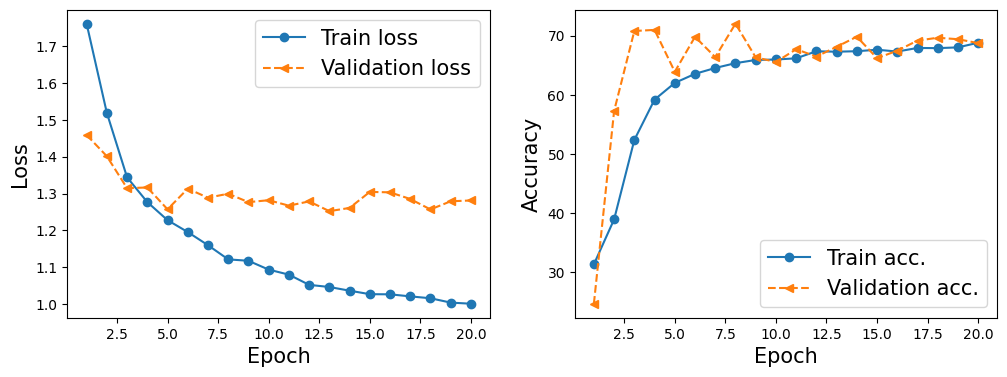

In [27]:
plot_history(long_hist)

Tranversal Acceleration

In [28]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_tranv = SimpleCNN()
optimizer_tranv = optim.Adam(model_tranv.parameters(), lr=0.00015558427999575448, weight_decay=1e-4)
scheduler_tranv = optim.lr_scheduler.ExponentialLR(optimizer_tranv, gamma=0.6560277884599833)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_tranv = model_tranv.to(device)

In [29]:
engine_tranv = simpleCNN_engine(model_tranv, optimizer_tranv, scheduler_tranv, criterion, device)

In [30]:
tranv_hist = engine_tranv.train_validation(train_dl_tranv, valid_dl_tranv, epochs=20, save_path='./model_checkpoint/run2_simpleCNN_tranv_chkpt.pth')

np.save('./model_checkpoint/run2_tranv_history.npy', np.array(tranv_hist))

   Epoch [1/20], Train Loss: 1.9712, Train Accuracy: 31.83%, Val Loss: 2.0513, Val Accuracy: 34.11%
   Epoch [2/20], Train Loss: 1.6318, Train Accuracy: 37.51%, Val Loss: 1.4291, Val Accuracy: 43.28%
   Epoch [3/20], Train Loss: 1.4013, Train Accuracy: 49.68%, Val Loss: 1.2625, Val Accuracy: 56.28%
   Epoch [4/20], Train Loss: 1.2955, Train Accuracy: 58.05%, Val Loss: 1.2406, Val Accuracy: 68.10%
   Epoch [5/20], Train Loss: 1.2303, Train Accuracy: 60.61%, Val Loss: 1.2289, Val Accuracy: 68.73%
   Epoch [6/20], Train Loss: 1.1915, Train Accuracy: 62.63%, Val Loss: 1.2135, Val Accuracy: 66.71%
   Epoch [7/20], Train Loss: 1.1780, Train Accuracy: 63.60%, Val Loss: 1.2136, Val Accuracy: 64.92%
   Epoch [8/20], Train Loss: 1.1538, Train Accuracy: 64.29%, Val Loss: 1.2101, Val Accuracy: 65.75%
   Epoch [9/20], Train Loss: 1.1471, Train Accuracy: 64.57%, Val Loss: 1.2034, Val Accuracy: 66.08%
   Epoch [10/20], Train Loss: 1.1454, Train Accuracy: 64.70%, Val Loss: 1.2133, Val Accuracy: 67.19%

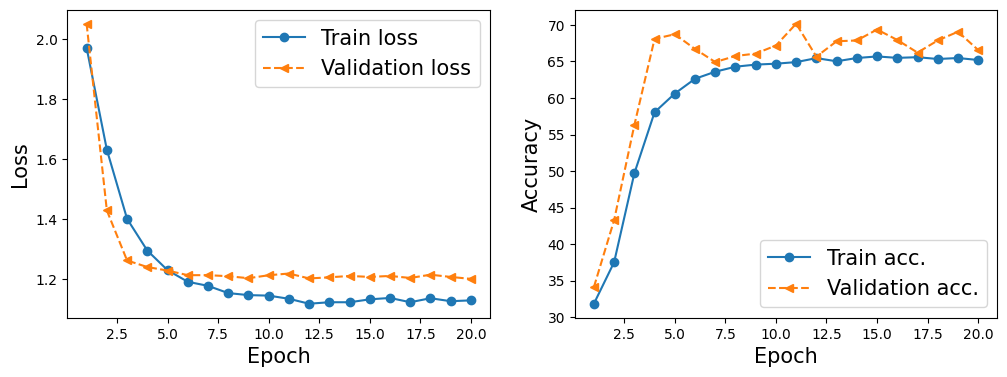

In [31]:
plot_history(tranv_hist)

Angular Velocity

In [32]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_ang = SimpleCNN()
optimizer_ang = optim.Adam(model_ang.parameters(), lr=0.00013662142756319453, weight_decay=1e-4)
scheduler_ang = optim.lr_scheduler.ExponentialLR(optimizer_ang, gamma=0.4740572036017916)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ang = model_ang.to(device)

In [33]:
engine_ang = simpleCNN_engine(model_ang, optimizer_ang, scheduler_ang, criterion, device)

In [34]:
ang_hist = engine_ang.train_validation(train_dl_angvel, valid_dl_angvel, epochs=20, save_path='./model_checkpoint/run2_simpleCNN_angvel_chkpt.pth')

np.save('./model_checkpoint/run2_angvel_history.npy', np.array(ang_hist))

   Epoch [1/20], Train Loss: 1.5027, Train Accuracy: 54.33%, Val Loss: 1.3446, Val Accuracy: 67.18%
   Epoch [2/20], Train Loss: 1.3517, Train Accuracy: 58.30%, Val Loss: 1.2751, Val Accuracy: 69.12%
   Epoch [3/20], Train Loss: 1.2339, Train Accuracy: 60.66%, Val Loss: 1.2363, Val Accuracy: 57.67%
   Epoch [4/20], Train Loss: 1.1628, Train Accuracy: 62.59%, Val Loss: 1.2235, Val Accuracy: 63.56%
   Epoch [5/20], Train Loss: 1.1432, Train Accuracy: 63.07%, Val Loss: 1.2136, Val Accuracy: 63.40%
   Epoch [6/20], Train Loss: 1.1287, Train Accuracy: 63.04%, Val Loss: 1.2025, Val Accuracy: 66.25%
   Epoch [7/20], Train Loss: 1.1232, Train Accuracy: 63.28%, Val Loss: 1.1972, Val Accuracy: 61.84%
   Epoch [8/20], Train Loss: 1.1144, Train Accuracy: 63.63%, Val Loss: 1.2024, Val Accuracy: 62.72%
   Epoch [9/20], Train Loss: 1.1186, Train Accuracy: 63.63%, Val Loss: 1.1975, Val Accuracy: 63.81%
   Epoch [10/20], Train Loss: 1.1182, Train Accuracy: 63.57%, Val Loss: 1.1920, Val Accuracy: 61.86%

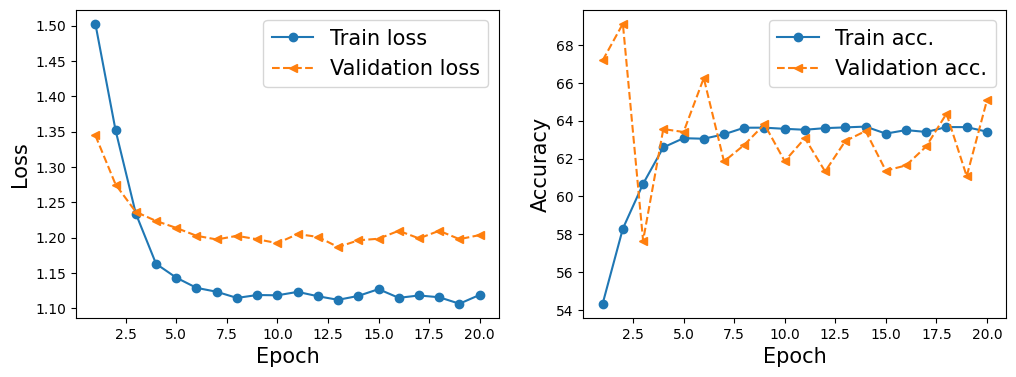

In [35]:
plot_history(ang_hist)

Testing the model on the test set drawn from the windowed_df[training]

In [40]:
## I can use any engine for this
engine_long.test_all(model_long, model_tranv, model_ang, 
                     test_dl_long, test_dl_tranv, test_dl_angvel)

Agreement accuracy among models: 0.7217186743236699


Seeing as the original data was split to get training, validation and test set (64:16:20), this means that the models were trained on just 64% of the training data instead of 70%, leaving 6% for val. Now that we're done testing, we can train the validation set.

#### Endgame Training
Longitudinal Acceleration

In [23]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_long = SimpleCNN()
optimizer_long = optim.Adam(model_long.parameters(), lr=0.00011113828101205411, weight_decay=1e-4)
scheduler_long = optim.lr_scheduler.ExponentialLR(optimizer_long, gamma=0.8492356384312725)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_long = model_long.to(device)

In [24]:
# Load the checkpoint
checkpoint = torch.load('./model_checkpoint/run2_simpleCNN_long_chkpt.pth')

# Load the different states
model_long.load_state_dict(checkpoint['model_state_dict'])
optimizer_long.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_long.load_state_dict(checkpoint['scheduler_state_dict'])

# Load the loss
loss = checkpoint['loss']

print(f'Loaded states from checkpoint with loss: {loss}')

Loaded states from checkpoint with loss: 0.6895003318786621


In [25]:
engine_long = simpleCNN_engine(model_long, optimizer_long, scheduler_long, criterion, device)

In [26]:
long_endgame_hist = engine_long.train_endgame(valid_dl_long, epochs=20,
                                              save_path='./model_checkpoint/endgame_2_simpleCNN_long_chkpt.pth')
np.save('./model_checkpoint/endgame_2_long_history.npy', np.array(long_endgame_hist))

   Epoch [1/20], Train Loss: 1.4268, Train Accuracy: 62.78%
   Epoch [2/20], Train Loss: 1.3788, Train Accuracy: 63.16%
   Epoch [3/20], Train Loss: 1.3547, Train Accuracy: 62.35%
   Epoch [4/20], Train Loss: 1.3365, Train Accuracy: 62.53%
   Epoch [5/20], Train Loss: 1.3130, Train Accuracy: 62.28%
   Epoch [6/20], Train Loss: 1.3204, Train Accuracy: 62.07%
   Epoch [7/20], Train Loss: 1.3304, Train Accuracy: 62.72%
   Epoch [8/20], Train Loss: 1.3084, Train Accuracy: 63.13%
   Epoch [9/20], Train Loss: 1.2825, Train Accuracy: 62.80%
   Epoch [10/20], Train Loss: 1.2799, Train Accuracy: 62.42%
   Epoch [11/20], Train Loss: 1.2841, Train Accuracy: 63.10%
   Epoch [12/20], Train Loss: 1.2914, Train Accuracy: 62.71%
   Epoch [13/20], Train Loss: 1.2764, Train Accuracy: 63.16%
   Epoch [14/20], Train Loss: 1.2812, Train Accuracy: 62.77%
   Epoch [15/20], Train Loss: 1.3214, Train Accuracy: 63.08%
   Epoch [16/20], Train Loss: 1.2525, Train Accuracy: 63.18%
   Epoch [17/20], Train Loss: 1.3

Tranversal Acceleration

In [27]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_tranv = SimpleCNN()
optimizer_tranv = optim.Adam(model_tranv.parameters(), lr=0.00015558427999575448, weight_decay=1e-4)
scheduler_tranv = optim.lr_scheduler.ExponentialLR(optimizer_tranv, gamma=0.6560277884599833)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_tranv = model_tranv.to(device)

In [28]:
# Load the checkpoint
checkpoint = torch.load('./model_checkpoint/run2_simpleCNN_tranv_chkpt.pth')

# Load the different states
model_tranv.load_state_dict(checkpoint['model_state_dict'])
optimizer_tranv.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_tranv.load_state_dict(checkpoint['scheduler_state_dict'])

# Load the loss
loss = checkpoint['loss']

print(f'Loaded states from checkpoint with loss: {loss}')

Loaded states from checkpoint with loss: 1.0944734811782837


In [29]:
engine_tranv = simpleCNN_engine(model_tranv, optimizer_tranv, scheduler_tranv, criterion, device)

In [30]:
tranv_endgame_hist = engine_tranv.train_endgame(valid_dl_tranv, epochs=20,
                                              save_path='./model_checkpoint/endgame_2_simpleCNN_tranv_chkpt.pth')
np.save('./model_checkpoint/endgame_2_tranv_history.npy', np.array(tranv_endgame_hist))

   Epoch [1/20], Train Loss: 1.3552, Train Accuracy: 63.54%
   Epoch [2/20], Train Loss: 1.3456, Train Accuracy: 63.56%
   Epoch [3/20], Train Loss: 1.3653, Train Accuracy: 63.45%
   Epoch [4/20], Train Loss: 1.3478, Train Accuracy: 63.61%
   Epoch [5/20], Train Loss: 1.3345, Train Accuracy: 63.42%
   Epoch [6/20], Train Loss: 1.3461, Train Accuracy: 63.13%
   Epoch [7/20], Train Loss: 1.3283, Train Accuracy: 63.15%
   Epoch [8/20], Train Loss: 1.3304, Train Accuracy: 63.45%
   Epoch [9/20], Train Loss: 1.3592, Train Accuracy: 63.35%
   Epoch [10/20], Train Loss: 1.3656, Train Accuracy: 63.09%
   Epoch [11/20], Train Loss: 1.3457, Train Accuracy: 63.45%
   Epoch [12/20], Train Loss: 1.3653, Train Accuracy: 63.24%
   Epoch [13/20], Train Loss: 1.3599, Train Accuracy: 63.12%
   Epoch [14/20], Train Loss: 1.3675, Train Accuracy: 63.49%
   Epoch [15/20], Train Loss: 1.3756, Train Accuracy: 63.70%
   Epoch [16/20], Train Loss: 1.3352, Train Accuracy: 63.62%
   Epoch [17/20], Train Loss: 1.3

Angular Velocity

In [31]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model_ang = SimpleCNN()
optimizer_ang = optim.Adam(model_ang.parameters(), lr=0.00013662142756319453, weight_decay=1e-4)
scheduler_ang = optim.lr_scheduler.ExponentialLR(optimizer_ang, gamma=0.4740572036017916)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ang = model_ang.to(device)

In [32]:
# Load the checkpoint
checkpoint = torch.load('./model_checkpoint/run2_simpleCNN_angvel_chkpt.pth')

# Load the different states
model_ang.load_state_dict(checkpoint['model_state_dict'])
optimizer_ang.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_ang.load_state_dict(checkpoint['scheduler_state_dict'])

# Load the loss
loss = checkpoint['loss']

print(f'Loaded states from checkpoint with loss: {loss}')

Loaded states from checkpoint with loss: 1.460357427597046


In [33]:
engine_ang = simpleCNN_engine(model_ang, optimizer_ang, scheduler_ang, criterion, device)

In [34]:
ang_endgame_hist = engine_ang.train_endgame(valid_dl_angvel, epochs=20,
                                              save_path='./model_checkpoint/endgame_2_simpleCNN_angvel_chkpt.pth')
np.save('./model_checkpoint/endgame_2_angvel_history.npy', np.array(tranv_endgame_hist))

   Epoch [1/20], Train Loss: 1.3782, Train Accuracy: 61.72%
   Epoch [2/20], Train Loss: 1.3834, Train Accuracy: 61.45%
   Epoch [3/20], Train Loss: 1.3971, Train Accuracy: 61.76%
   Epoch [4/20], Train Loss: 1.3570, Train Accuracy: 61.91%
   Epoch [5/20], Train Loss: 1.3784, Train Accuracy: 61.52%
   Epoch [6/20], Train Loss: 1.3999, Train Accuracy: 61.62%
   Epoch [7/20], Train Loss: 1.3696, Train Accuracy: 61.90%
   Epoch [8/20], Train Loss: 1.4101, Train Accuracy: 61.23%
   Epoch [9/20], Train Loss: 1.3516, Train Accuracy: 62.17%
   Epoch [10/20], Train Loss: 1.3763, Train Accuracy: 61.78%
   Epoch [11/20], Train Loss: 1.3662, Train Accuracy: 61.96%
   Epoch [12/20], Train Loss: 1.3631, Train Accuracy: 61.52%
   Epoch [13/20], Train Loss: 1.3584, Train Accuracy: 61.71%
   Epoch [14/20], Train Loss: 1.3772, Train Accuracy: 61.72%
   Epoch [15/20], Train Loss: 1.3667, Train Accuracy: 61.84%
   Epoch [16/20], Train Loss: 1.4011, Train Accuracy: 61.39%
   Epoch [17/20], Train Loss: 1.4

Plotting only Long_hist and Tranv_hist as I've lost the first ang_hist data

In [35]:
from src.plot import plot_endgame_history
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
long_hist = np.load('./model_checkpoint/run2_long_history.npy')
tranv_hist = np.load('./model_checkpoint/run2_tranv_history.npy')
ang_hist = np.load('./model_checkpoint/run2_angvel_history.npy')

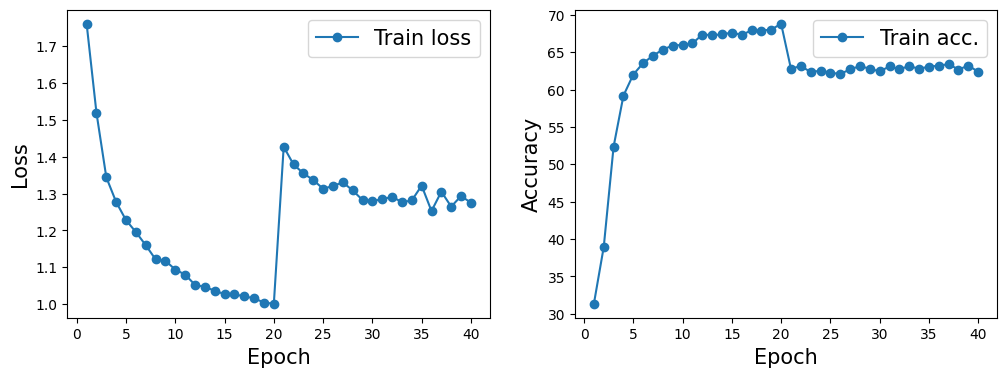

In [37]:
plot_endgame_history(long_endgame_hist, long_hist)

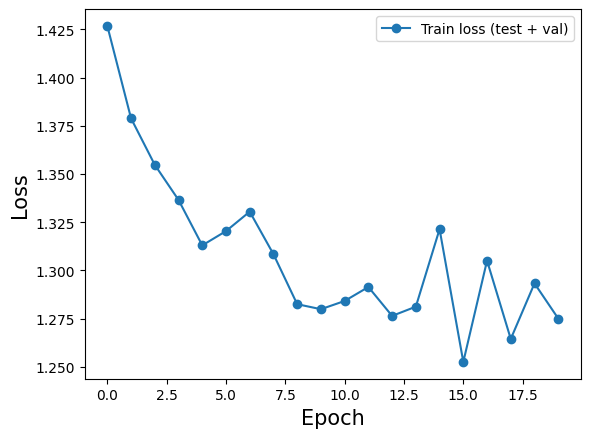

In [38]:
plt.plot(np.arange(len(long_endgame_hist[0])), long_endgame_hist[0], '-o', label='Train loss (test + val)')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.legend()
plt.show()

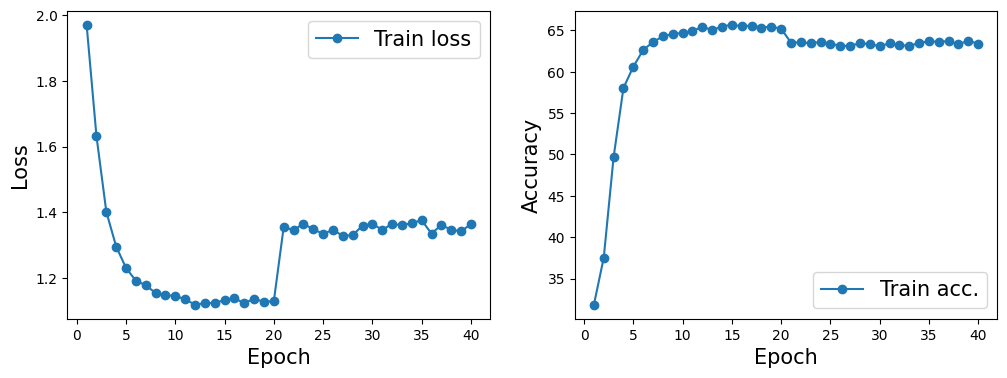

In [39]:
plot_endgame_history(tranv_endgame_hist, tranv_hist)

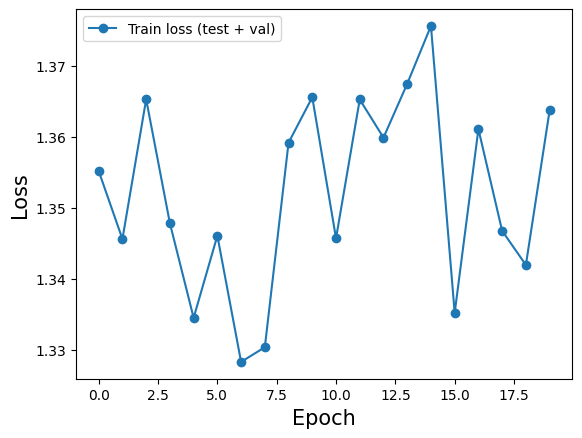

In [40]:
plt.plot(np.arange(len(tranv_endgame_hist[0])), tranv_endgame_hist[0], '-o', label='Train loss (test + val)')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.legend()
plt.show()

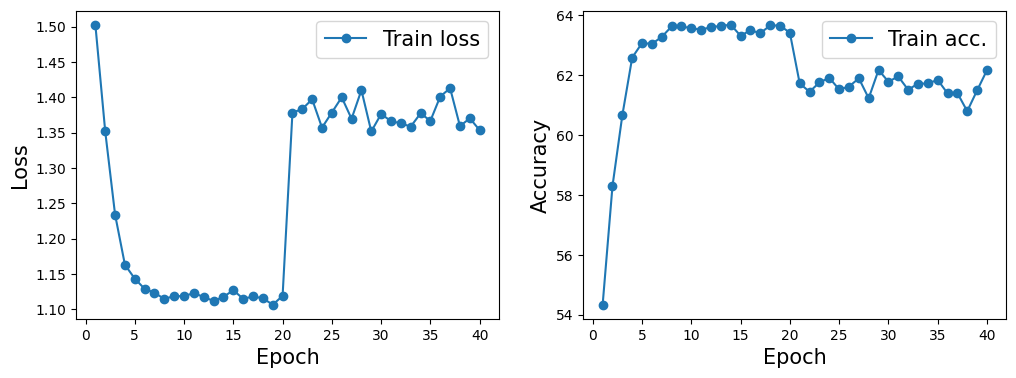

In [41]:
plot_endgame_history(ang_endgame_hist, ang_hist)

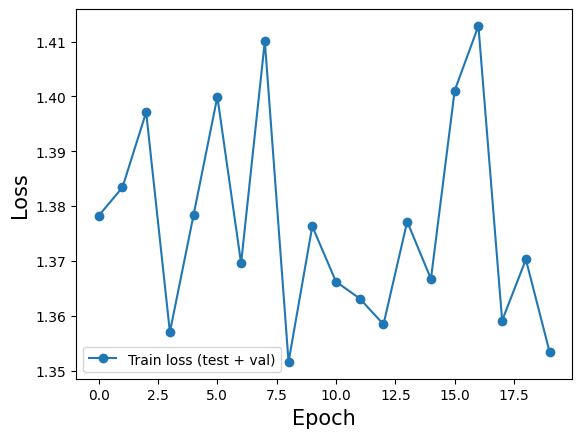

In [42]:
plt.plot(np.arange(len(ang_endgame_hist[0])), ang_endgame_hist[0], '-o', label='Train loss (test + val)')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.legend()
plt.show()

In [43]:
## I can use any engine for this
engine_long.test_all(model_long, model_tranv, model_ang, 
                     test_dl_long, test_dl_tranv, test_dl_angvel)

Agreement accuracy among models: 0.6756382757904933


#### Feature Maps Extraction

In [44]:
def converter(instr):
    return np.fromstring(instr[1:-1],sep=' ')

windowed_df = pd.read_csv(
    './data/full_windowed_df.csv',
    converters={
        'long_acc_window': converter,
        'tranv_acc_window': converter,
        'ang_vel_window': converter
    }
)

In [45]:
print(windowed_df.user.unique())
print(windowed_df.query('coarse_label==5.0').user.unique())

['Not_driving' 'User1' 'User2' 'User3']
['User1' 'User2' 'User3']


recall `tr_idx_nondupe` and `tr_idx_interp` created above. I'll use it to split my data to get training and validation

In [46]:
TR_tr_idx_nondupe, VAL_tr_idx_nondupe = train_test_split(tr_idx_nondupe,
                                                    test_size=0.2,
                                                    stratify=windowed_df.loc[tr_idx_nondupe, 'user_act'].values,
                                                    random_state=42)

TR_tr_idx_interp, VAL_tr_idx_interp = train_test_split(tr_idx_interp,
                                                  test_size=0.2,
                                                  stratify=windowed_df.loc[tr_idx_interp, 'user_act'].values,
                                                  random_state=42)

# get the idx for the duplicates
TR_tr_idx_dupe = TR_tr_idx_nondupe+1
VAL_tr_idx_dupe = VAL_tr_idx_nondupe+1

# get new training and validation set
TR_train_idx = np.concatenate([TR_tr_idx_nondupe, TR_tr_idx_dupe, TR_tr_idx_interp], axis=None)
VAL_train_idx = np.concatenate([VAL_tr_idx_nondupe, VAL_tr_idx_dupe, VAL_tr_idx_interp], axis=None)

Now I have `train_idx` from that I have `TR_train_idx` (training), `VAL_train_idx` (validation) and `test_idx` (testing)

In [47]:
len(test_idx), len(TR_train_idx), len(VAL_train_idx)

(14453, 46240, 11563)

In [48]:
X_tr, y_tr, _ = Prep_data_for_CNN().prep_input_for_CNN(windowed_df.loc[TR_train_idx, :])
X_val, y_val, _ = Prep_data_for_CNN().prep_input_for_CNN(windowed_df.loc[VAL_train_idx, :])
X_test, y_test, _ = Prep_data_for_CNN().prep_input_for_CNN(windowed_df.loc[test_idx, :])


# Create datasets for each feature
feature_indices = {'long_acc': 0, 'tranv_acc': 1, 'ang_vel': 2}

## dataset for extracting feature maps from data
TR_all_dataset = {feature: SignalsDataset((X_tr-mean)/std, y_tr, idx) for feature, idx in feature_indices.items()}
VAL_all_dataset = {feature: SignalsDataset((X_val-mean)/std, y_val, idx) for feature, idx in feature_indices.items()}
TEST_all_dataset = {feature: SignalsDataset((X_test-mean)/std, y_test, idx) for feature, idx in feature_indices.items()}

In [49]:
# load current trained model state
# Load the checkpoint
checkpoint_l = torch.load('./model_checkpoint/endgame_2_simpleCNN_long_chkpt.pth')
checkpoint_t = torch.load('./model_checkpoint/endgame_2_simpleCNN_tranv_chkpt.pth')
checkpoint_a = torch.load('./model_checkpoint/endgame_2_simpleCNN_angvel_chkpt.pth')

# Load the different states
model_long.load_state_dict(checkpoint_l['model_state_dict'])
model_tranv.load_state_dict(checkpoint_t['model_state_dict'])
model_ang.load_state_dict(checkpoint_a['model_state_dict'])

<All keys matched successfully>

In [50]:
batch_size = 1

# dataloaders
TR_dataloaders = {
      'long': DataLoader(TR_all_dataset['long_acc'], batch_size, shuffle=False),
      'tranv': DataLoader(TR_all_dataset['tranv_acc'], batch_size, shuffle=False),
      'angvel': DataLoader(TR_all_dataset['ang_vel'], batch_size, shuffle=False)
}
VAL_dataloaders = {
      'long': DataLoader(VAL_all_dataset['long_acc'], batch_size, shuffle=False),
      'tranv': DataLoader(VAL_all_dataset['tranv_acc'], batch_size, shuffle=False),
      'angvel': DataLoader(VAL_all_dataset['ang_vel'], batch_size, shuffle=False)
}
TEST_dataloaders = {
      'long': DataLoader(TEST_all_dataset['long_acc'], batch_size, shuffle=False),
      'tranv': DataLoader(TEST_all_dataset['tranv_acc'], batch_size, shuffle=False),
      'angvel': DataLoader(TEST_all_dataset['ang_vel'], batch_size, shuffle=False)
}

In [51]:
# models
models = {
      'long': model_long,
      'tranv': model_tranv,
      'angvel': model_ang
}

In [52]:
from src.preprocess import FeatureMaps_extractor

In [53]:
idx_lists = [TR_train_idx, VAL_train_idx, test_idx]
dataloaders = [TR_dataloaders, VAL_dataloaders, TEST_dataloaders]
splits = ['train', 'valid', 'test']
base_dir = './data/feature_maps_labels/'

for i in range(len(idx_lists)):
      feature_extractor = FeatureMaps_extractor(base_dir, device, idx_lists[i], splits[i])
      feature_extractor.feature_map_extractor(models, dataloaders[i], splits[i])

Extracting Feature Maps test: 100%|██████████| 14453/14453 [02:04<00:00, 116.31it/s]


Done. Total file size = `40.7 GB (43,803,578,368 bytes)`

In [54]:
test = np.load('./data/feature_maps_labels/train/10002.npy')

In [55]:
test.shape

(3, 224, 224)

In [56]:
test

array([[[-8.16360414e-02,  4.78573710e-01, -8.40168476e-01, ...,
         -2.22032249e-01,  7.07064494e-02, -2.57724762e-01],
        [ 2.97466904e-01, -1.28953016e+00, -1.27021897e+00, ...,
          3.82092521e-02,  6.04807734e-02,  1.69129163e-01],
        [ 1.09014976e+00,  2.16618037e+00, -2.97740608e-01, ...,
          2.55739037e-02, -1.75157875e-01,  2.15569377e-01],
        ...,
        [-4.22323376e-01,  1.24451947e+00, -1.09783101e+00, ...,
          1.49238437e-01,  1.30221337e-01,  1.06817521e-01],
        [-1.18651462e+00, -4.73963797e-01, -1.02510417e+00, ...,
         -1.68773413e-01, -3.15741271e-01, -1.33159816e-01],
        [ 1.09627768e-01, -1.01654992e-01, -1.94163769e-01, ...,
         -3.40037465e-01, -1.70686439e-01, -9.19869393e-02]],

       [[ 1.73653513e-01, -1.37913615e-01,  4.26242203e-01, ...,
         -5.18541932e-01, -3.88835579e-01, -2.23628968e-01],
        [-4.26551282e-01, -5.58969200e-01, -7.41269648e-01, ...,
         -7.97137082e-01, -4.26398844e

#### Split lstm_features into training and test too.

In [57]:
from src.preprocess import Save_Lstm_Feats_n_Labs
from tqdm import tqdm

In [58]:
lstm_features = np.load('./data/lstm_features_labels/full_lstm_features.npy')
lstm_labels = np.load('./data/lstm_features_labels/full_lstm_labels.npy')

In [59]:
lstm_features.shape

(72256, 112, 6)

In [60]:
np.unique(lstm_labels)

array([1., 2., 3., 4., 5., 6., 7., 8.])

~~We are interested in knowing whether the signal is taken in a car or not. This means our positive class is `5.0` and the rest are negative.~~ I have decided to do a full on transport mode classification. So all I'll do is shift the labels by 1 so that start from 0.

In [61]:
#lstm_labels_mapped = np.where(lstm_labels == 5, 1.0, 0.0)
lstm_labels_mapped = lstm_labels - 1.0

In [62]:
np.unique(lstm_labels_mapped)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [63]:
idx_lists = [TR_train_idx, VAL_train_idx, test_idx]
splits = ['train', 'valid', 'test']
base_dir = './data/lstm_features_labels/'

lstm_saver = Save_Lstm_Feats_n_Labs(base_dir)
for i in range(len(idx_lists)): 
      for j in tqdm(range(len(idx_lists[i])), desc=f"Saving Lstm Feat and Labels: {splits[i]}"):
            idx = idx_lists[i][j]
            lstm_saver.save_combined_feature_map(lstm_features[idx], lstm_labels_mapped[idx],
                                                 splits[i], idx)

Saving Lstm Feat and Labels: test: 100%|██████████| 14453/14453 [00:13<00:00, 1089.38it/s]
